In [34]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from skimage import img_as_ubyte
from sklearn.cluster import KMeans
from sklearn.utils import shuffle


class ImageProcessor:
    def __init__(self, image_path):
        self.image_path = image_path
        self.image = self._load_image()
        self.whitebalanced_image = None
        self.quantized_image = None
        self.color_group = None

    def _load_image(self):
        # 이미지 로드 (OpenCV는 BGR로 이미지를 로드하므로 RGB로 변환합니다)
        image = cv2.imread(self.image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Convert to floats instead of the default 8 bits integer coding.
        image = np.array(image, dtype=np.float64) / 255
        return image

    def apply_whitebalance(self, percentile_value=95):
        self.whitebalanced_image = img_as_ubyte(
            (self.image * 1.0 / np.percentile(self.image, percentile_value, axis=(0, 1))).clip(0, 1)
        )
        return self.whitebalanced_image

    def apply_kmeans_quantization(self, n_colors=5, background_threshold=244):
        if self.whitebalanced_image is None:
            raise ValueError("Please apply whitebalance before quantization.")
        
        # Convert image to uint8 and [0, 255] range if needed
        image = self.whitebalanced_image
        if image.dtype == np.float64 and np.max(image) <= 1.0:
            image = (image * 255).astype(np.uint8)
        
        # Create a mask to exclude the background
        mask = np.all(image > background_threshold, axis=-1)
        masked_image = image[~mask]

        # Reshape the masked image to a 2D array of pixels
        w, h, d = original_shape = tuple(image.shape)
        image_array = masked_image.reshape(-1, d)

        # Fit the KMeans model on the masked image data
        image_array_sample = shuffle(image_array, random_state=0, n_samples=1000)
        kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)

        # Predict color indices for the masked pixels
        labels = kmeans.predict(image_array)

        # Recreate the image
        quantized_image = np.full_like(image, fill_value=255)  # Start with a white image
        quantized_image[~mask] = kmeans.cluster_centers_[labels].astype(np.uint8)
        self.quantized_image = quantized_image

        # Calculate color percentages and counts
        label_counts = np.bincount(labels)
        percentages = np.around(((label_counts / len(labels)) * 100), 2)
        colors = []
        for i, (percentage, count) in enumerate(zip(percentages, label_counts)):
            color = kmeans.cluster_centers_[i].astype(int)
            colors.append(color.tolist())
        
        self.color_group = sorted(zip(colors, percentages), key=lambda x: x[1], reverse=True)
        return self.quantized_image, self.color_group

    def process_image(self, percentile_value=95, n_colors=5, background_threshold=244):
        return self.apply_whitebalance(percentile_value), self.apply_kmeans_quantization(n_colors, background_threshold)


# 사용 예시
# image_path = "/root/ai/dataset/puppy_poo/dataset_cls_train_aug_apply/train/7/Diarrhoea_309_jpg.rf.79da5532346844f92a59762b658a9cb3.jpg"
image_path = "/root/ai/a-rang-pddong.jpg"
processor = ImageProcessor(image_path)

# 화이트 밸런스 적용 및 색상 양자화 실행
whitebalanced_image, (quantized_image, color_group) = processor.process_image()
for color, percentage in color_group:
    print(f"Color: {color}, Percentage: {percentage:.2f}%")

Color: [174, 147, 119], Percentage: 32.23%
Color: [199, 180, 161], Percentage: 20.16%
Color: [236, 232, 227], Percentage: 16.30%
Color: [138, 109, 93], Percentage: 15.90%
Color: [78, 47, 38], Percentage: 15.42%


(-0.5, 963.5, 963.5, -0.5)

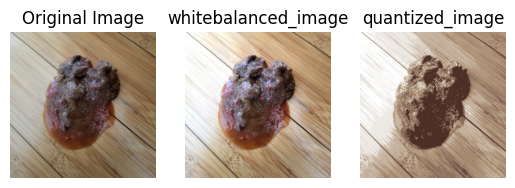

In [35]:
import matplotlib.pyplot as plt
# 이미지 로드 (OpenCV는 BGR로 이미지를 로드하므로 RGB로 변환합니다)
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(whitebalanced_image)
plt.title("whitebalanced_image")
plt.axis("off")
plt.subplot(1, 3, 3)
plt.imshow(quantized_image)
plt.title("quantized_image")
plt.axis("off")


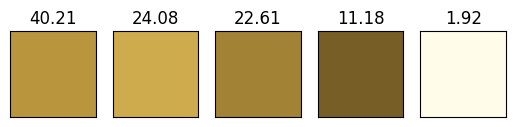

In [33]:
import matplotlib.pyplot as plt
for idx, (color, per) in enumerate(color_group):
    plt.subplot(1, len(color_group), idx + 1)
    plt.xticks([])
    plt.yticks([])
    plt.title(per)
    col = np.zeros((100, 100, 3), dtype=np.uint8)
    col[:, :, :] = color
    plt.imshow(col)